# Text translation: hindi to english

## Importing Libraries

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

words = set(nltk.corpus.words.words())
%matplotlib inline

## Importing Dataset

In [2]:
df = pd.read_csv('hindi_english_parallel.csv')

## EDA

In [3]:
df.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [4]:
df.shape

(1561841, 2)

In [5]:
df.info(verbose=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561841 entries, 0 to 1561840
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   hindi    1555785 non-null  object
 1   english  1561116 non-null  object
dtypes: object(2)
memory usage: 23.8+ MB


In [6]:
df.describe().T

,count,unique,top,freq
hindi,1555785,983939,Name,1093
english,1561116,1015945,Your names,363


In [7]:
df.duplicated().sum()

203501

In [8]:
df[df['hindi'] == 'Name']

,hindi,english
146241,Name,A download from a camera or other device has f...
146243,Name,A queue in the batch queue manager has been co...
146245,Name,The update of the fingerprint database has bee...
146247,Name,The update of the thumbnails database has been...
146384,Name,Acquire Images
...,...,...
241847,Name,WorKflow support for the Kate editor
241849,Name,WorKflow file command library
241851,Name,WorKflow command library for image manipulation
241853,Name,WorKflow command library for text manipulation


## Dataset Cleaning

In [9]:
def remove_english(sent):
    return " ".join([x for x in sent.split() if x.lower() not in words])

In [10]:
df.dropna(inplace=True)

In [11]:
df['hindi'] = df['hindi'].apply(remove_english)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [12]:
df.describe().T

,count,unique,top,freq
hindi,1331153,955290,,2401
english,1331153,1011562,light,123


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331153 entries, 0 to 1561839
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   hindi    1331153 non-null  object
 1   english  1331153 non-null  object
dtypes: object(2)
memory usage: 30.5+ MB


In [14]:
df['english'] = df['english'].apply(lambda x: x.lower())

<AxesSubplot:xlabel='hindi', ylabel='Count'>

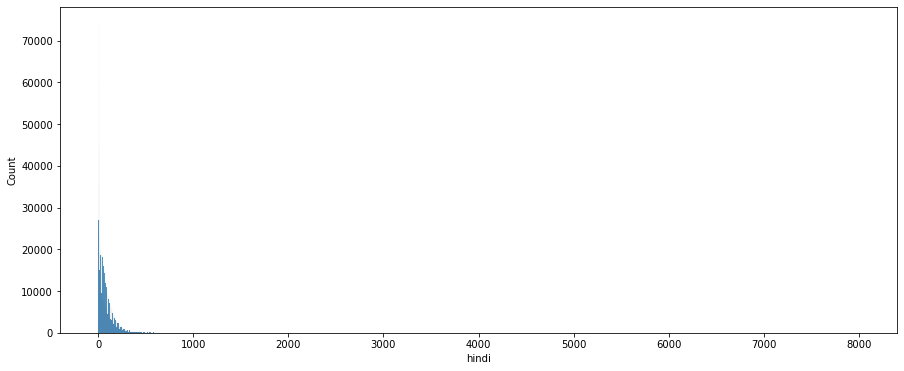

In [15]:
plt.figure(figsize=(15, 6))
sns.histplot(df['hindi'].apply(len))

<AxesSubplot:xlabel='english'>

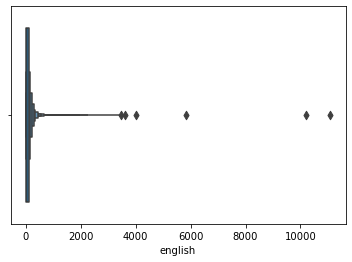

In [16]:
sns.boxenplot(x=df['english'].apply(len))

In [17]:
idx = df[df['hindi'].apply(len) > 1000].index
df.drop(idx, inplace=True)

<AxesSubplot:xlabel='hindi', ylabel='Count'>

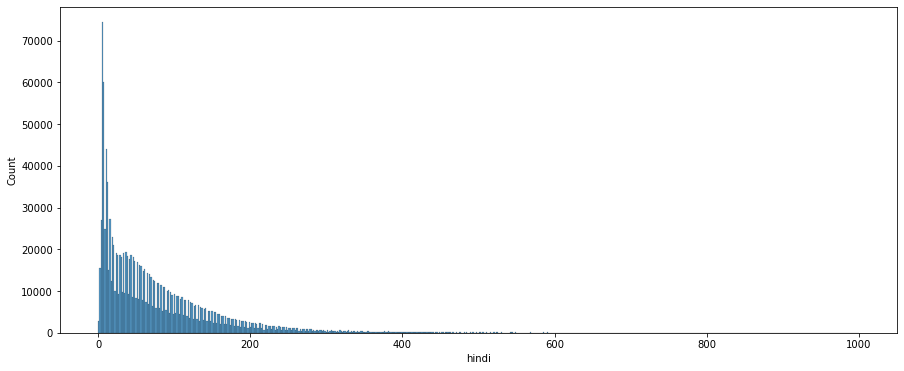

In [18]:
plt.figure(figsize=(15, 6))
sns.histplot(df['hindi'].apply(len))

In [19]:
df.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,accerciser accessibility explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,the default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,the default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,a list of plugins that are disabled by default


## Train Test Split

In [20]:
df = df.sample(n=500000, random_state=42)

In [21]:
X = df['hindi']
y= df['english']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
y.head()

145881                              increase expansion level
1144305    any innovation due to an industrial applicatio...
904025                               commercial exploitation
802441                                              entrance
1348320                          by now it was getting dark.
Name: english, dtype: object

## Encoding train and test sets

In [23]:
# may take up to 33 seconds
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(str(lines))
    return tokenizer

In [24]:
# may take up to 50 seconds
hin_tokenizer = create_tokenizer(X)
hin_vocab_size = len(hin_tokenizer.word_index) + 1

eng_tokenizer = create_tokenizer(y)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

In [25]:
def encode_sequences(tokenizer, lines):
    X = tokenizer.texts_to_sequences(str(lines))
    X = pad_sequences(X, padding='post')
    return X

In [26]:
def encode_output(sequences, vocab_size):
    ylist = list()
    for seq in sequences:
        encoded = to_categorical(seq, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    
    return y

In [27]:
len(X_train)

350000

In [28]:
# prepare training data
trainX = encode_sequences(hin_tokenizer, X_train)
trainY = encode_sequences(eng_tokenizer, X_test)
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(hin_tokenizer, y_train)
testY = encode_sequences(eng_tokenizer, y_test)
testY = encode_output(testY, eng_vocab_size)

## Training NN model

In [59]:
def define_model(hin_vocab_size, eng_vocab_size, hin_len, eng_len, n):
    model = Sequential()
    model.add(Embedding(hin_vocab_size, n, input_length=hin_len, mask_zero=True))
    model.add(LSTM(n))
    model.add(RepeatVector(eng_len))
    model.add(LSTM(n, return_sequences=True))
    model.add(TimeDistributed(Dense(eng_vocab_size, activation='softmax')))
    
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    
    # summarize the model
    model.summary()
    return model

In [60]:
model = define_model(hin_vocab_size, eng_vocab_size, len(X), 1, 256)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500000, 256)       19200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 1, 256)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 256)            525312    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 35)             8995      
Total params: 1,078,819
Trainable params: 1,078,819
Non-trainable params: 0
_________________________________________________________________


In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [63]:
model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY), callbacks=[early_stop, checkpoint])

Epoch 1/50
12/12 [==============================] - 0s 19ms/step - loss: 0.2381 - val_loss: 4.9900

Epoch 00001: val_loss did not improve from 3.31592
Epoch 2/50
12/12 [==============================] - 0s 11ms/step - loss: 0.2362 - val_loss: 5.0100

Epoch 00002: val_loss did not improve from 3.31592
Epoch 3/50
12/12 [==============================] - 0s 12ms/step - loss: 0.2331 - val_loss: 5.0221

Epoch 00003: val_loss did not improve from 3.31592
Epoch 4/50
12/12 [==============================] - 0s 11ms/step - loss: 0.2313 - val_loss: 5.0397

Epoch 00004: val_loss did not improve from 3.31592
Epoch 5/50
12/12 [==============================] - 0s 11ms/step - loss: 0.2299 - val_loss: 5.0534

Epoch 00005: val_loss did not improve from 3.31592
Epoch 6/50
12/12 [==============================] - 0s 12ms/step - loss: 0.2262 - val_loss: 5.0675

Epoch 00006: val_loss did not improve from 3.31592
Epoch 00006: early stopping


In [37]:
trainX.shape

(713, 1)

In [38]:
trainY.shape

(713, 1, 35)

In [39]:
testX.shape

(715, 1)

In [40]:
testY.shape

(715, 1, 35)

In [42]:
len(X)

500000

In [43]:
len(y)

500000